In [ ]:
# Yarden Dahan, 208730523

# Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sn
import cv2
import glob
# from wcmatch import glob as gb
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch
import random
# import torch_optimizer as optim
from torchvision import transforms
from matplotlib import pyplot as plt
from imgaug import augmenters as iaa
from  sklearn.model_selection import train_test_split
from  sklearn.metrics import confusion_matrix
# import pretrainedmodels
from tqdm.notebook import tqdm
import requests
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
# from google.colab import auth
from oauth2client.client import GoogleCredentials
# Albumentations
from albumentations import (
  HorizontalFlip, IAAPerspective, ShiftScaleRotate,VerticalFlip, CLAHE, RandomRotate90,Rotate,
    Transpose, ShiftScaleRotate, Blur,RandomGamma, OpticalDistortion, GridDistortion,HorizontalFlip, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

import pprint

In [ ]:
print("""
          _.-\"\"\"-._
         /  _   _  \\
        /  (9) (9)  \\
       /_,         ,_\\     <Remember me?>
       | \\         / |
_      \\  \\._____./  /  __
\\`\\     \\   \\___/   / _|  \\
 \\ `\\   /\\         /\\ \\   /
  |  `\\/ /`'-----'`\\ \\/  /
  |_|\\/ /           \\   /
  /    /|           |\\_/
  \\___/ |           | \\
   \\ .  |           |  \\
    \\|  |           |  |
     |  `.         .'  |
     \\    `-.___.-'    /
     `\\       |       /'
       `\\     |     /'
    .-.-.`\\   |   /'.-.-.
   (,(,(,`^   |   ^`,),),)
    '-'-'-----`-----'-'-'
""")


          _.-"""-._
         /  _   _  \
        /  (9) (9)  \
       /_,         ,_\     <Remember me?>
       | \         / |
_      \  \._____./  /  __
\`\     \   \___/   / _|  \
 \ `\   /\         /\ \   /
  |  `\/ /`'-----'`\ \/  /
  |_|\/ /           \   /
  /    /|           |\_/
  \___/ |           | \
   \ .  |           |  \
    \|  |           |  |
     |  `.         .'  |
     \    `-.___.-'    /
     `\       |       /'
       `\     |     /'
    .-.-.`\   |   /'.-.-.
   (,(,(,`^   |   ^`,),),)
    '-'-'-----`-----'-'-'



# Load Data

In [ ]:
drive.mount('/content/gdrive')
images_dir="/content/gdrive/My Drive/Afeka_FaceData2022"
all_paths = [ f.path for f in os.scandir(images_dir) if f.is_dir() ]
all_paths
len(all_paths)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


9

## Store the images and label them

{   'Amber Heard': 1,
    'Channing Tatum': 4,
    'Cristiano Ronaldo': 2,
    'Johnny Depp': 0,
    'Lionel Messi': 5,
    'Luka Doncic': 3,
    'Morgan Freeman': 8,
    'Ronaldinho': 6,
    'Shahar Hason': 7}
#images = 180
/content/gdrive/My Drive/Afeka_FaceData2022/Lionel Messi/2.jpg


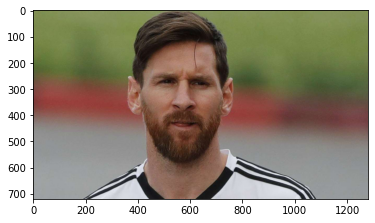

In [ ]:
images_paths=[]
images_paths_student=[]
for path in all_paths:
  images_paths_student.append([ f.path for f in os.scandir(path) ])

for file in images_paths_student:
  images_paths+=(file)
#labels
pp = pprint.PrettyPrinter(indent=4)
images_map={}
for i in range(len(all_paths)):
  images_map[all_paths[i].split("/")[-1]]=i

pp.pprint(images_map)
print(f"#images = {len(images_paths)}\n{images_paths[100]}")
plt.imshow(plt.imread(images_paths[100]))

## Train, test split
* test- 20%
* train- 80%

In [ ]:
data = pd.DataFrame(columns=['image','label','name'])
def load_data(paths=images_paths,label_map = images_map, test_size=0.2):
    test_size = test_size
    for i in range(len(paths)):
      image = plt.imread(paths[i])
      image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)

      name = paths[i].split("/")[-2]
      label = images_map[name]
      data.loc[i] = [image,label,name]

    x_train, x_test, y_train, y_test = train_test_split(data['image'], data['label'],test_size=test_size)
    return ((x_train.reset_index().drop("index", axis=1), y_train.reset_index().drop("index", axis=1)), 
    (x_test.reset_index().drop("index", axis=1), y_test.reset_index().drop("index", axis=1)))    

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()
print(f'total.length={len(data)}\n\ntrain.length = {len(x_train)}\ntest.length= {len(x_test)}')
data.head()

total.length=180

train.length = 144
test.length= 36


image label         name
0  [[[139, 0, 12], [139, 1, 13], [138, 1, 13], [1...     0  Johnny Depp
1  [[[190, 197, 233], [190, 197, 233], [190, 197,...     0  Johnny Depp
2  [[[87, 87, 97], [87, 87, 97], [87, 87, 97], [8...     0  Johnny Depp
3  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...     0  Johnny Depp
4  [[[182, 154, 130], [182, 154, 130], [184, 156,...     0  Johnny Depp

# Show Images


In [ ]:
# function to return key for any value
def get_key(my_dict,val):
  for k,v in images_map.items():
    if val == v:
      return k
  return "key doesn't exist"

def show_images(num_classes,data = data,rows = 4, cols = 4):
  fig = plt.figure(figsize=(cols*5, rows*5), dpi=80)

  for i in range(num_classes):
    row = data.loc[data['label'] == i].reset_index().loc[0]
    image = row['image']
    label = row['label']
    name = row['name']
    
    fig.add_subplot(rows, cols, i+1)
    plt.title(name)
    plt.axis("off")
    plt.imshow(image)        

    if len(image) != 3:
      plt.imshow(image, cmap=plt.cm.gray)
    else:
      plt.imshow(image)        
  plt.show()
def show_images_transforms(images_list,tag_list,cols,rows):
  plt.figure(figsize=[cols*5, rows*5])

  for i in range(len(images_list)):
    image = images_list[i]
    
    plt.subplot(rows, cols, i+1)
    plt.title(tag_list[i])
    plt.axis("off")
    if len(image) != 3:
        plt.imshow(image, cmap=plt.cm.gray)
    else:
      plt.imshow(image)        
  plt.show()



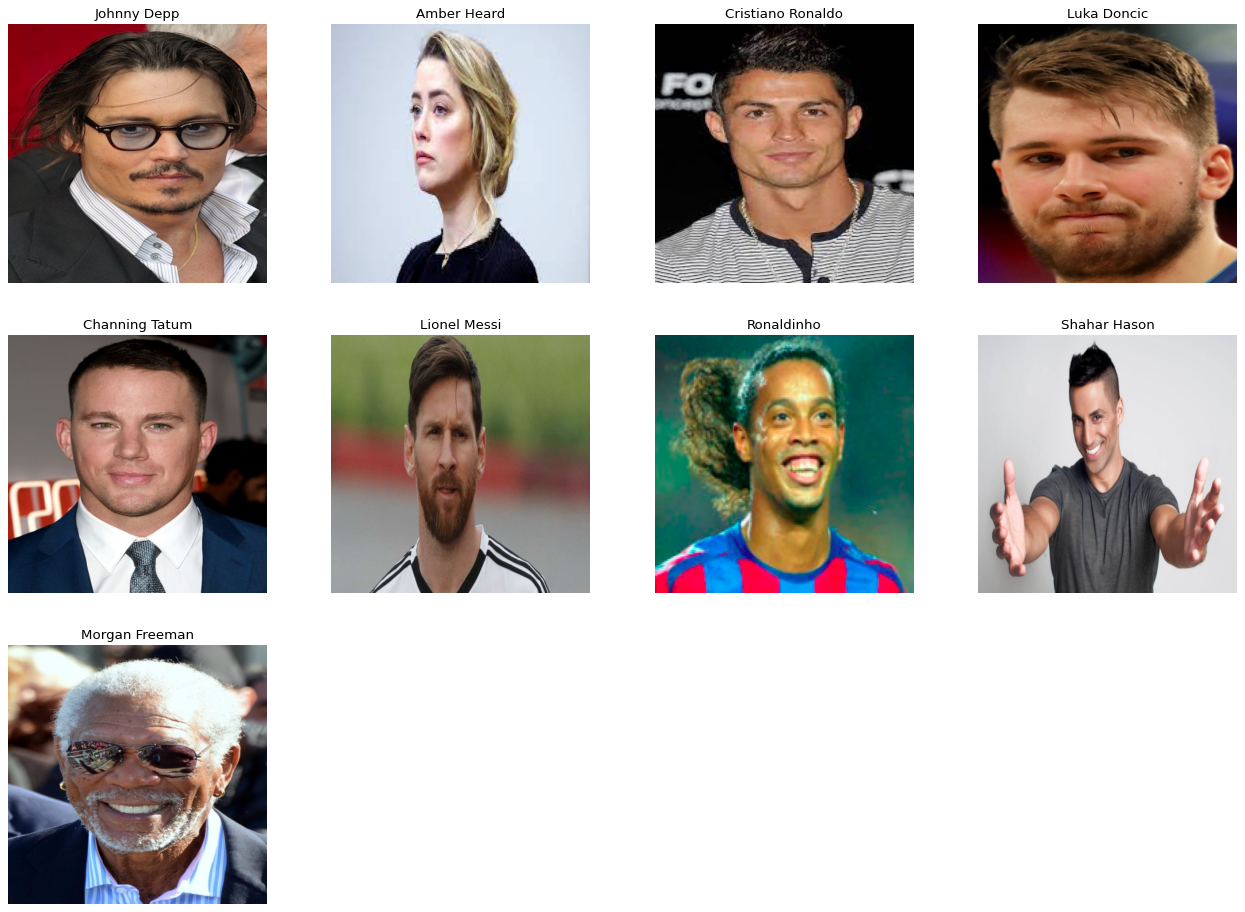

In [ ]:
num_classes = len(images_map)
show_images(num_classes,rows = 6, cols = 4)

# Dataset class-


In [ ]:
class MyDataset(Dataset):
  def __init__(self,data,target = None, transforms=None, train= True, test=False,label_map = images_map):
    self.data = data
    self.label_map = label_map
    if not test:
      self.target = target
    self.transforms= transforms
    self.train=train
    self.test=test

  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    image = self.data.loc[idx]["image"]
    if self.train:
      if self.transforms:
        image = np.asarray(image)
        image = image.astype(np.uint8)
        image = self.transforms(image=image, label='label')['image']
    # image = np.float32(image)
    # image = torch.from_numpy(image)
    if self.test:
      return image 
    else:
      label = self.target.loc[idx]["label"]
      name = get_key(self.label_map,label)
      return image,name,label


# Augmentation report
1. HorizontalFlip: 
  * This augmentation makes the image horizontal
  * Does not destroy the data
  * Helps the network not to make a mistake when it comes to an image with inverted faces
2. HueSaturationValue:
  * Changes hue, saturation of the image - that is, simulates different light conditions.
  * Too large values will ruin the image, this augmentation helps the network not to make a mistake when the image arrives in different light conditions

3. ShiftScaleRotate:
  * shifting, resizing and rotating an image at different angles
  * helps the network not to make a mistake when the image comes rotated or shifted at different deception angles
  * too big shift_limit and scale_limit Can ruin our image
4. Rotate:
  * Helps the network not to make mistakes when the image comes in different biases.
  * Does not harm our image - great values will make it overturn.
    * Note: Not all images are upside down so values that are too large can impair the network's learning ability.
  * border mode - black borders or pixel borders of the image (this kind of border can adversely affect the learning of the network)
5. Median Blur:
  * helps the network not to make a mistake when the image comes out blurry
  * Values that are too large can blur the image too much so that we do not recognize the face
6. MotionBlur:
  * Helps the network not to make a mistake when the image arrives blurry
  * Values that are too large can obscure the image so much that we will not recognize the face
7. Blur:
  * Helps the network not to make a mistake when the image arrives blurry
8. RandomBrightnessContrast:
  * Changes the brightness and contrast of the image at random simulates different light conditions
    * helps the network not to make a mistake when the image arrives different light conditions
    * Values that are too large can change the values of the snippets so that the image is destroyed, such as causing black or white image.
9. RandomGamma:
  * changes the gamma of the image. That is, it simulates different light conditions. 
  * helping the network in different light conditions. 
  * Too low values in gamma_limit will ruin the image and make it too dark.
10. GaussNoise:
  * adds noise to the image
  * helps the network not to make a mistake when the image comes with noise
11. CLAHE:
  * Adds Contrast 
  * helps the network practice on on data that comes with contrast
12. IAASharpen:
  * Sharpen the color values
  * helps the network to practice on data that comes in different light conditions

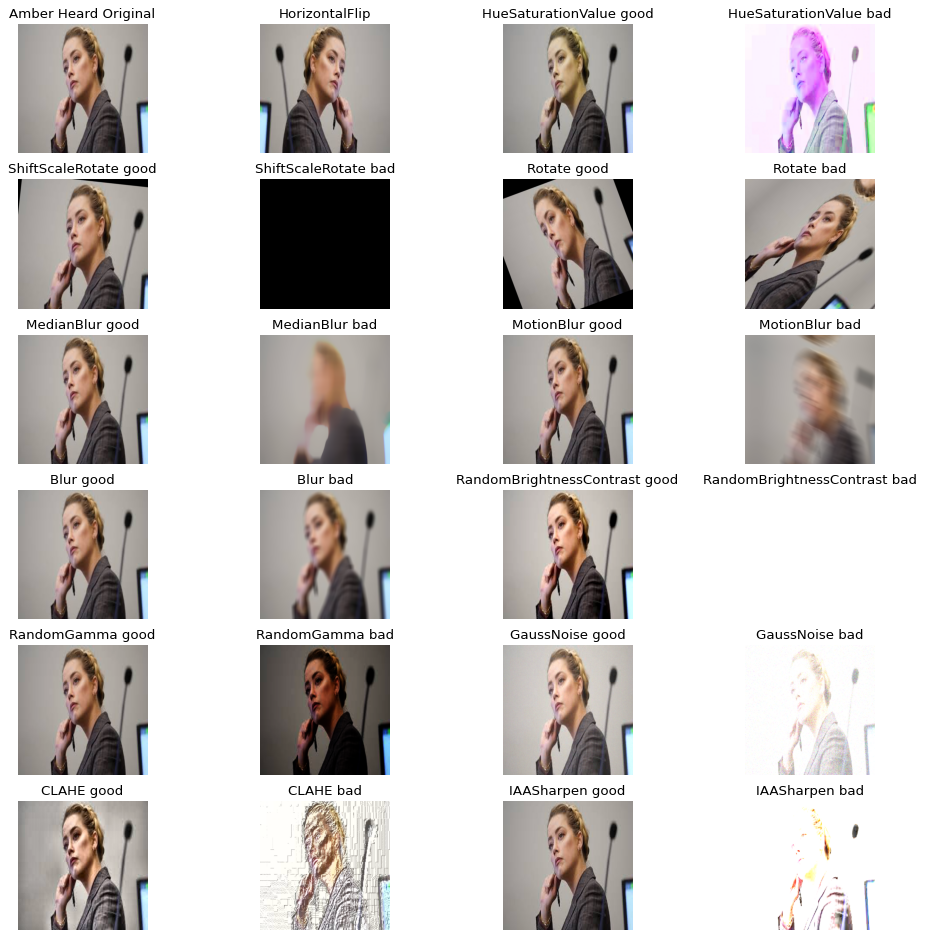

In [ ]:
def add_subplot_images(name,image, rows, cols,i):
  fig.add_subplot(rows, cols, i)
  plt.title(name)
  plt.axis("off")
  plt.imshow(image)   
  return i+1

fig = plt.figure(figsize=(15, 15), dpi=80)
i = 1
rows = 6
cols = 4
image = x_train.loc[20]["image"]
name = get_key(images_map,y_train.loc[20]["label"])
#Original image
i = add_subplot_images(name+" Original",image,rows, cols, i)
# HorizontalFlip
hflip = HorizontalFlip(p=1)
i = add_subplot_images("HorizontalFlip",hflip(image=image)['image'],rows, cols, i)
# HueSaturationValue
good = HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=30, p=1)
i = add_subplot_images("HueSaturationValue good",good(image=image, label='label')['image'],rows, cols, i)
bad = HueSaturationValue(hue_shift_limit=255, sat_shift_limit=0, val_shift_limit=255, p=1)
i = add_subplot_images("HueSaturationValue bad",bad(image=image, label='label')['image'],rows, cols, i)  
# ShiftScaleRotate
good = ShiftScaleRotate(rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=1)
i = add_subplot_images("ShiftScaleRotate good",good(image=image, label='label')['image'],rows, cols, i)
bad = ShiftScaleRotate(shift_limit=150, scale_limit=150, border_mode=cv2.BORDER_CONSTANT, p=1)
i = add_subplot_images("ShiftScaleRotate bad",bad(image=image, label='label')['image'],rows, cols, i)  
# Rotate
good = Rotate(limit=30, border_mode=cv2.BORDER_CONSTANT, p=1)
i = add_subplot_images("Rotate good",good(image=image, label='label')['image'],rows, cols, i)
bad = Rotate(limit=180, p=1)
i = add_subplot_images("Rotate bad",bad(image=image, label='label')['image'],rows, cols, i)  
# MedianBlur
good = MedianBlur(blur_limit=3, p=1)
i = add_subplot_images("MedianBlur good",good(image=image, label='label')['image'],rows, cols, i)
bad = MedianBlur(blur_limit=200,  p=1)
i = add_subplot_images("MedianBlur bad",bad(image=image, label='label')['image'],rows, cols, i)
# MotionBlur
good = MotionBlur(blur_limit=3, p=1)
i = add_subplot_images("MotionBlur good",good(image=image, label='label')['image'],rows, cols, i)
bad = MotionBlur(blur_limit=200,  p=1)
i = add_subplot_images("MotionBlur bad",bad(image=image, label='label')['image'],rows, cols, i)    
# Blur
good = Blur(blur_limit=3, p=1)
i = add_subplot_images("Blur good",good(image=image, label='label')['image'],rows, cols, i)
bad = Blur(blur_limit=200,  p=1)
i = add_subplot_images("Blur bad",bad(image=image, label='label')['image'],rows, cols, i)          
# RandomBrightnessContrast
good = RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1)
i = add_subplot_images("RandomBrightnessContrast good",good(image=image, label='label')['image'],rows, cols, i)
bad =  RandomBrightnessContrast(brightness_limit=12, contrast_limit=12, p=1)
i = add_subplot_images("RandomBrightnessContrast bad",bad(image=image, label='label')['image'],rows, cols, i)     
# RandomGamma
good = RandomGamma(gamma_limit=(90, 120), p=1)
i = add_subplot_images("RandomGamma good",good(image=image, label='label')['image'],rows, cols, i)
bad =  RandomGamma(gamma_limit=(10, 40), p=1)
i = add_subplot_images("RandomGamma bad",bad(image=image, label='label')['image'],rows, cols, i)     
# GaussNoise
good = GaussNoise(var_limit=(10.0, 80.0), p=1)
i = add_subplot_images("GaussNoise good",good(image=image, label='label')['image'],rows, cols, i)
bad =  GaussNoise(var_limit=(1000.0, 2000.0), p=1)
i = add_subplot_images("GaussNoise bad",bad(image=image, label='label')['image'],rows, cols, i) 
# CLAHE
good = CLAHE(clip_limit=5, p=1)
i = add_subplot_images("CLAHE good",good(image=image, label='label')['image'],rows, cols, i)
bad =  CLAHE(clip_limit=500, tile_grid_size=(2000,2000), p=1)
i = add_subplot_images("CLAHE bad",bad(image=image, label='label')['image'],rows, cols, i) 
# IAASharpen
good = IAASharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1)
i = add_subplot_images("IAASharpen good",good(image=image, label='label')['image'],rows, cols, i)
bad =  IAASharpen(alpha=(0.2, 0.5), lightness=(15.0, 20.0), p=1)
i = add_subplot_images("IAASharpen bad",bad(image=image, label='label')['image'],rows, cols, i) 

# Transform

In [ ]:
train_transform=Compose([
    OneOf([
          Blur(blur_limit=3, p=1), MotionBlur(blur_limit=3, p=1),MedianBlur(blur_limit=3, p=1)]),

          GaussNoise(var_limit=(10.0, 80.0), p=1), 
          IAASharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1),
          CLAHE(clip_limit=5, p=1),
          RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1),
          RandomGamma(gamma_limit=(90, 120), p=1),
          HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=30, p=1),

          OneOf([
                HorizontalFlip(p=1),Rotate(limit=30, border_mode=cv2.BORDER_CONSTANT, p=1),  
                ShiftScaleRotate(rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=1)]),
])

# DataLoader

In [ ]:
BS=4
 
trainset=MyDataset(data = x_train,target = y_train ,transforms=train_transform, train=True,label_map=images_map)
train_loader= DataLoader(trainset,batch_size=BS,shuffle=True, num_workers=2)#, pin_memory=True)

testset=MyDataset(data = x_test, train=False, test=True)
test_loader= DataLoader(testset,batch_size=BS,shuffle=False, num_workers=4)#, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


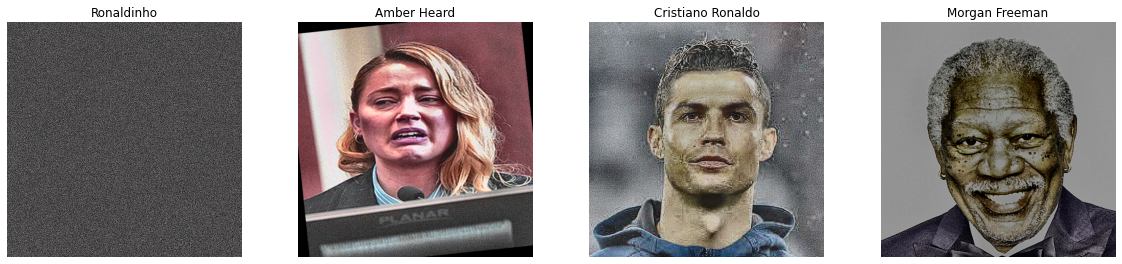

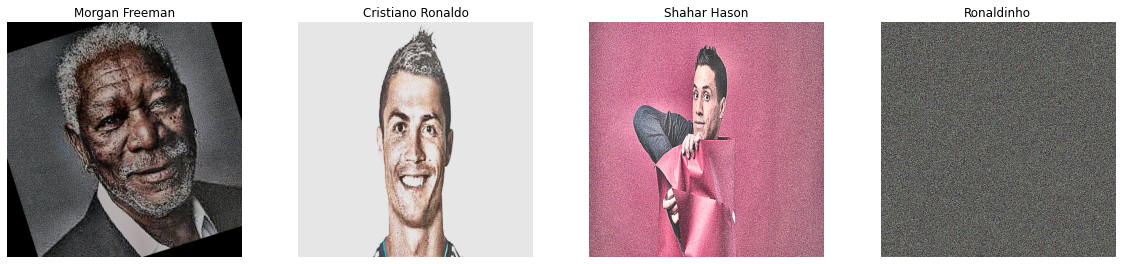

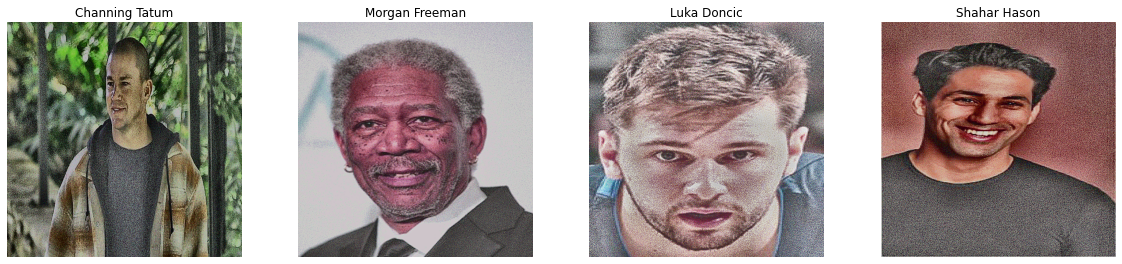

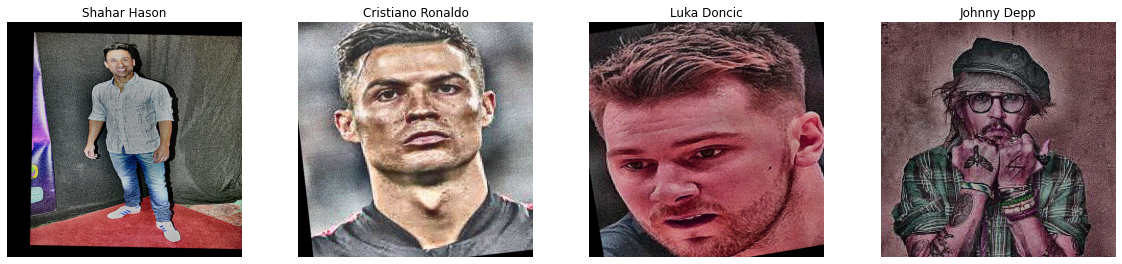

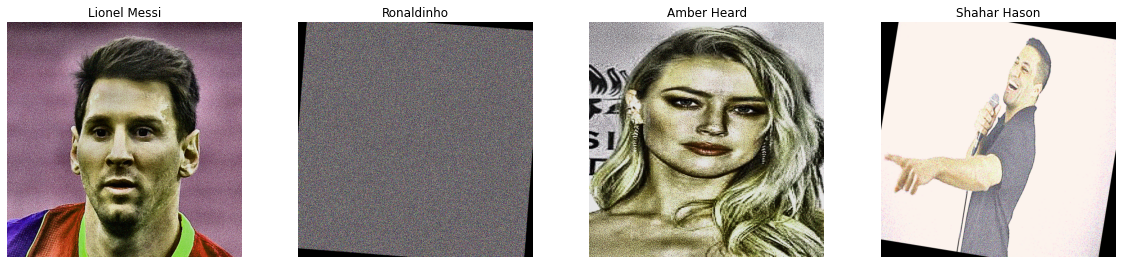

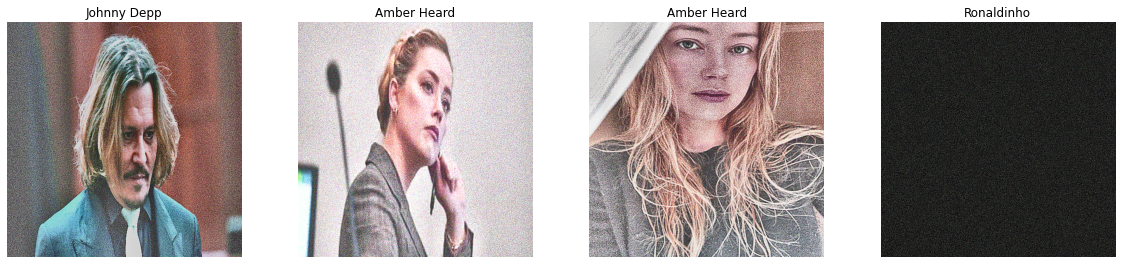

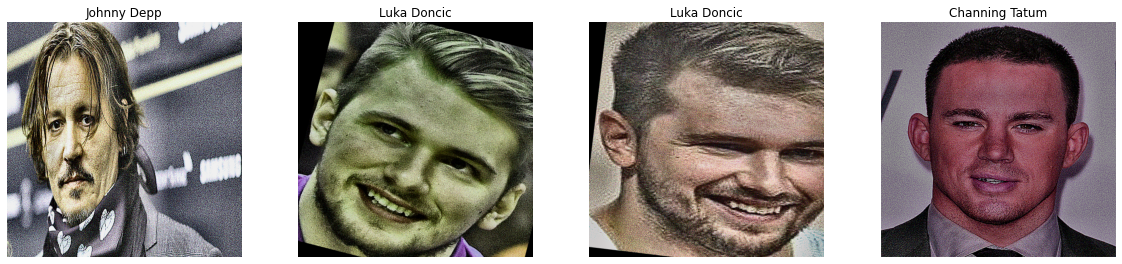

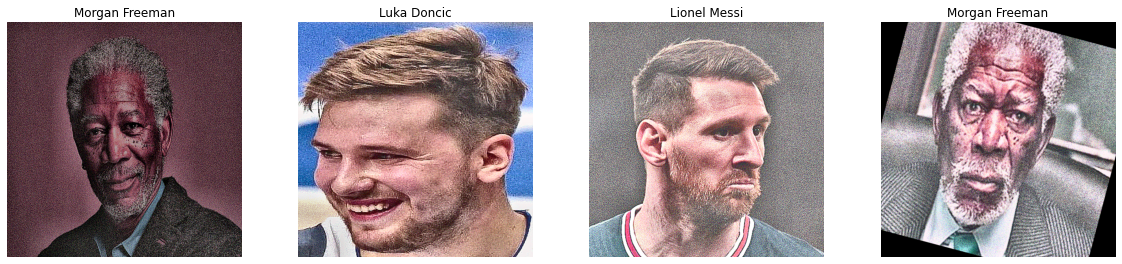

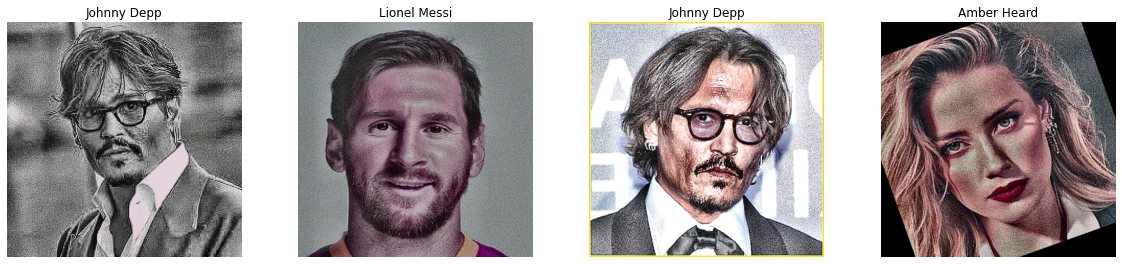

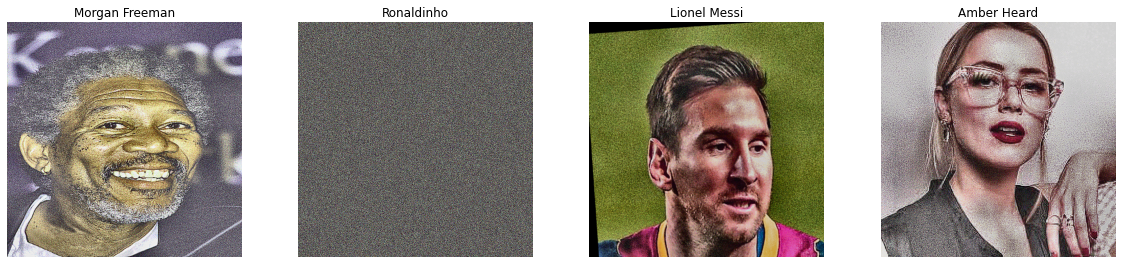

In [ ]:
for i, (images, names, labels) in enumerate(train_loader):
  if i < 10 :
    np_images = images.numpy()
    show_images_transforms(np_images, names,4, 5)
  else:
    break

# Face Transfer
* using model from OPENCV (pip install opencv-python)
and the function recognize_face I created a rectangle that marks the position of the face

In [ ]:
# SOURCE = "https://towardsdatascience.com/face-detection-in-2-minutes-using-opencv-python-90f89d7c0f81"
def recognize_face(image):
  # Load the cascade
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')    
  # Convert to grayscale
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # show gray image
  plt.imshow(gray_image)
  # Detect the faces
  faces = face_cascade.detectMultiScale(gray_image, 1.1, 4)
  print(faces)
  # Draw the rectangle around each face
  for (x, y, w, h) in faces:
      cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
  # Display
  return image

# return only face rectangle
def get_face_box(image):
  # Load the cascade
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  # Convert to grayscale
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # Detect the faces
  return face_cascade.detectMultiScale(gray_image, 1.1, 4)

def add_lable(name1,name2):
  new_name1=""+name1+" and " +name2 + "'s face"
  new_name2=""+name2+" and " +name1 + "'s face"

  return new_name1,new_name2

def change_face(image1,name1,image2, name2, blur=0.8):
  # generate new lable
  name1,name2=add_lable(name1,name2)
  # get face box
  faces1 = get_face_box(image1)
  faces2 = get_face_box(image2)
  rgbimg1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
  rgbimg2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

  #cropped the face box from each image
  (x1, y1, w1, h1) = faces1[0]
  cropped1 =  rgbimg1[y1:y1+h1, x1:x1+w1]
  (x2, y2, w2, h2) = faces2[0]
  cropped2 = rgbimg2[y2:y2+h2, x2:x2+w2]

  #resize the box face
  resize1=cv2.resize(cropped1, (h2, w2) ,interpolation=cv2.INTER_AREA)
  resize2=cv2.resize(cropped2, (h1, w1), interpolation=cv2.INTER_AREA)

  #blur the box face
  blur_face1 = cv2.addWeighted(cropped2, 1-blur, resize1, blur, 0)
  blur_face2 = cv2.addWeighted(cropped1, 1-blur, resize2, blur, 0)

  #united face and image
  rgbimg1[y1:y1+h1, x1:x1+w1]=blur_face2
  rgbimg2[y2:y2+h2, x2:x2+w2]=blur_face1

  return rgbimg1,rgbimg2,name1,name2
  # show_images_transforms([rgbimg1,rgbimg2],[name1,name2],2,1)

[[ 55  38 261 261]]


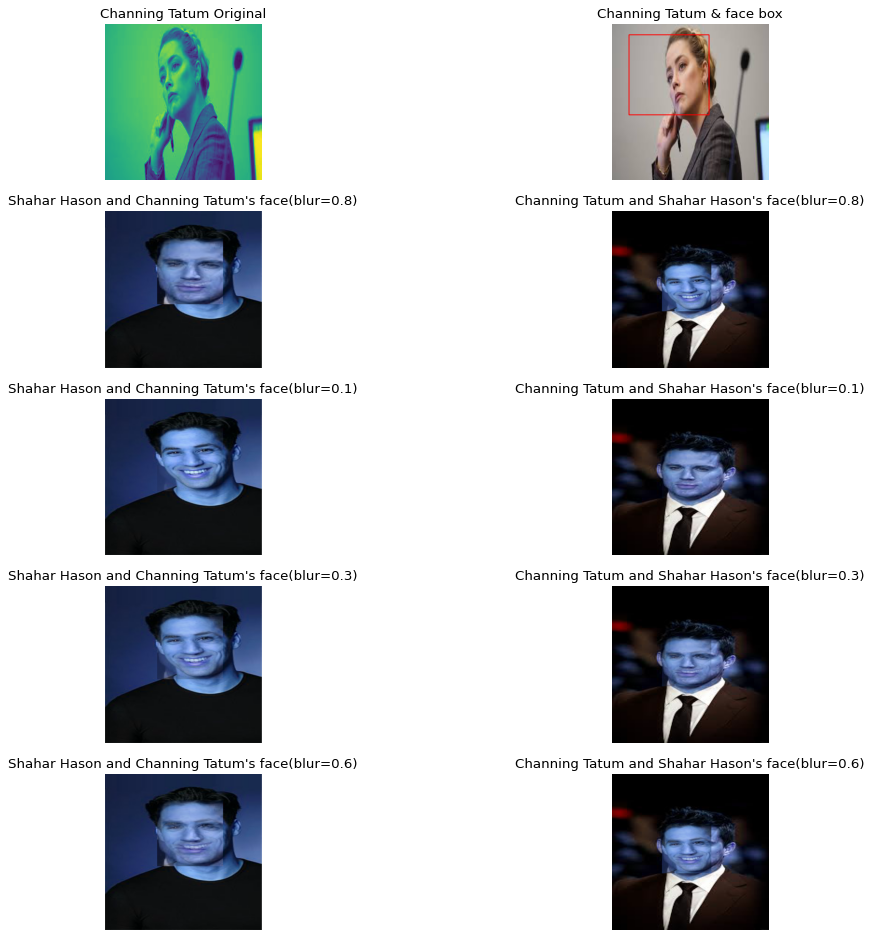

In [ ]:
fig = plt.figure(figsize=(15, 15), dpi=80)
i = 1
rows = 5
cols = 2
image_demo = x_train.loc[45]["image"]
name = get_key(images_map,y_train.loc[45]["label"])
#Original image
i = add_subplot_images(name+" Original",image_demo,rows, cols, i)
# image with face recognition
face_box_image = recognize_face(image)

i = add_subplot_images(name+" & face box",face_box_image,rows, cols, i)
# image with face recognition
image_demo1 = x_train.loc[70]["image"]
name_demo1 = get_key(images_map,y_train.loc[70]["label"])
image_demo2 = x_train.loc[32]["image"]
name_demo2 = get_key(images_map,y_train.loc[32]["label"])
new_image_demo1,new_image_demo2,new_name_demo1,new_name_demo2 = change_face(image_demo1,name_demo1,image_demo2, name_demo2, blur=0.8)
i = add_subplot_images(new_name_demo1 + "(blur=0.8)",new_image_demo1,rows, cols, i)
i = add_subplot_images(new_name_demo2 + "(blur=0.8)",new_image_demo2,rows, cols, i)

new_image_demo1,new_image_demo2,new_name_demo1,new_name_demo2 = change_face(image_demo1,name_demo1,image_demo2, name_demo2, blur=0.1)
i = add_subplot_images(new_name_demo1 + "(blur=0.1)",new_image_demo1,rows, cols, i)
i = add_subplot_images(new_name_demo2 + "(blur=0.1)",new_image_demo2,rows, cols, i)

new_image_demo1,new_image_demo2,new_name_demo1,new_name_demo2 = change_face(image_demo1,name_demo1,image_demo2, name_demo2, blur=0.3)
i = add_subplot_images(new_name_demo1 + "(blur=0.3)",new_image_demo1,rows, cols, i)
i = add_subplot_images(new_name_demo2 + "(blur=0.3)",new_image_demo2,rows, cols, i)

new_image_demo1,new_image_demo2,new_name_demo1,new_name_demo2 = change_face(image_demo1,name_demo1,image_demo2, name_demo2, blur=0.6)
i = add_subplot_images(new_name_demo1 + "(blur=0.6)",new_image_demo1,rows, cols, i)
i = add_subplot_images(new_name_demo2 + "(blur=0.6)",new_image_demo2,rows, cols, i)

* As can be seen the best blur value is 0.8

# Summary
First part:
1. I first uploaded the images from the drive and created a dataframe from them for convenience with a column for the label and the name of the label.
2. I created a dataset class, on which I ran a dataloader, which loads the images not from memory. And split the data using load_data() call.
3. I checked which augmentations can be performed on the images, there is a detailed detail above under the section - Augmentation report- about what each augmentation does and how it helps the network to learn, also details the meaning of the values ​​of the augmentation.
4. I presented the pictures without the augmentations, and with the augmentations as I was asked.

Second part:
1. I used the OPENCV model to identify the face in the image, after searching the internet I came across a face_cascade approach, which only works on gray images so it is important to convert to BGR2GRAY before using the cascade. 
2. I drew the boundaries I got from the model by a rectangle.
Now that we have the rectangle that marks the position of the face in the image.
3. I created a function that changes the face in the image to another face and 
4. I also created a new label.
* chang face function work in the following way:
  * I found the border of the face for each image
  * I cut out the square of the face and kept in memory
  * For each face I pasted the cropped face image of the other person.
  * To make the image consolidation less noticeable I added a blur that will help blur the borders.

In [ ]:
print("""
          _.-\"\"\"-._
         /  _   _  \\
        /  (9) (9)  \\
       /_,         ,_\\     <Barney says byeeee!!>
       | \\         / |
_      \\  \\._____./  /  __
\\`\\     \\   \\___/   / _|  \\
 \\ `\\   /\\         /\\ \\   /
  |  `\\/ /`'-----'`\\ \\/  /
  |_|\\/ /           \\   /
  /    /|           |\\_/
  \\___/ |           | \\
   \\ .  |           |  \\
    \\|  |           |  |
     |  `.         .'  |
     \\    `-.___.-'    /
     `\\       |       /'
       `\\     |     /'
    .-.-.`\\   |   /'.-.-.
   (,(,(,`^   |   ^`,),),)
    '-'-'-----`-----'-'-'
""")


          _.-"""-._
         /  _   _  \
        /  (9) (9)  \
       /_,         ,_\     <Barney says byeeee!!>
       | \         / |
_      \  \._____./  /  __
\`\     \   \___/   / _|  \
 \ `\   /\         /\ \   /
  |  `\/ /`'-----'`\ \/  /
  |_|\/ /           \   /
  /    /|           |\_/
  \___/ |           | \
   \ .  |           |  \
    \|  |           |  |
     |  `.         .'  |
     \    `-.___.-'    /
     `\       |       /'
       `\     |     /'
    .-.-.`\   |   /'.-.-.
   (,(,(,`^   |   ^`,),),)
    '-'-'-----`-----'-'-'

